# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="./fig/pic1.png"/>

Then you will want to run the above command:

<img src="./fig/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import json
import progressbar
from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score, recall_score, f1_score

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

E:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# <span id="0">Purpose of the Project</span>

The project aims to build **machine learning model** to predict three kind of issues, based on his/her personal information:
1. Which offer is most appropriate to a customer?
2. How is a customer related to offer? Does he/she only purchase when receive an offer?
3. Basically, what is the average transaction amount of a customer?

The offer type is from portfolio dataset:

<img src="./fig/offer_typs.jpg", width="500", height="400"/>

For the first issue, a classification model will be used. For the second and third issue, regression models will be used to predict.

Following is the main chapter of the project:

#  Content
## 1. [Walk through and Clean dataset](#1)
## 2. [Training model](#2)
## 3. [Conclusion](#3)

## <span id="1">1. Walk throught and Clean dataset</span>

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
profile.shape

(17000, 5)

In [5]:
# NaN value detection
profile.isna().sum(axis=0)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [7]:
# Turn became_member_on data into appropriate format
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

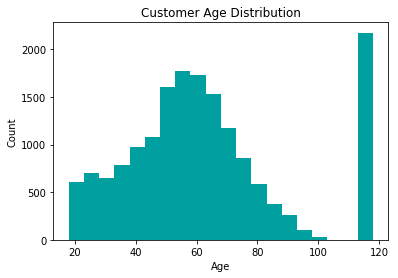

In [8]:
# Age distribution
plt.hist(profile.age, bins = 20, color = '#00A0A0');
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Customer Age Distribution');

There is quite a lot outliers in age data

In [9]:
profile[profile.age == profile.age.max()].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [10]:
profile[profile.age < profile.age.max()].count()

age                 14825
became_member_on    14825
gender              14825
id                  14825
income              14825
dtype: int64

In [11]:
profile.age.max()

118

People with age at 118 seems like to be defaulted by app since all of them have no data in gender or income.
The best way to deal is to remove them from dataset. Since our demographic machine learning can't deal with these customers in either training or testing.

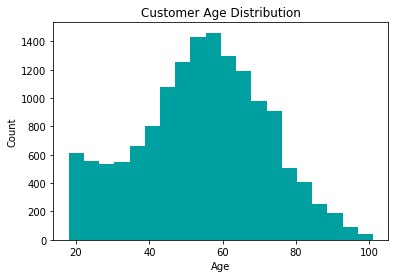

In [12]:
plt.hist(profile[profile.age < 118].age, bins = 20, color = '#00A0A0');
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Customer Age Distribution');

After remove outliers, the histogram seems reasonable.

In [13]:
# Remove these outliers in another dataset
profile_remove = profile[profile.age == 118]
profile = profile[profile.age < 118].reset_index(drop=True)

In [14]:
profile.duplicated().sum()

0

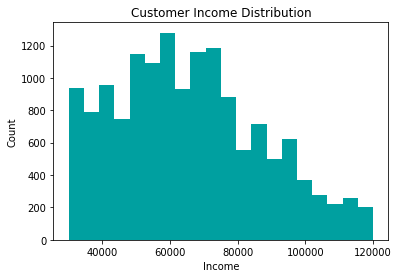

In [15]:
# Income distribution
plt.hist(profile.income, bins = 20, color = '#00A0A0');
plt.xlabel('Income');
plt.ylabel('Count');
plt.title('Customer Income Distribution');

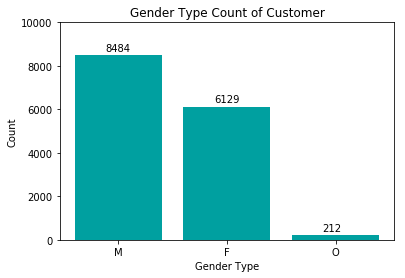

In [16]:
# Look into gender ratio
gender = pd.DataFrame(profile.gender.value_counts())
plt.bar(range(gender.shape[0]), gender.values.reshape(1, -1)[0], color = '#00A0A0');
plt.xticks(range(gender.shape[0]), gender.index);
for i in range(gender.shape[0]):
    plt.text(i-0.12, gender.values.reshape(1, -1)[0][i]+200, gender.values.reshape(1, -1)[0][i]);
plt.ylim(0, 10000);
plt.xlabel('Gender Type');
plt.ylabel('Count');
plt.title('Gender Type Count of Customer');

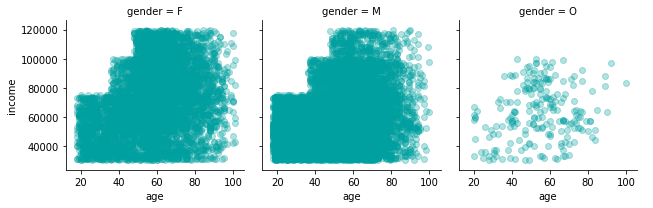

In [17]:
# visualize the 3 factors'(age, income ,gender) relationship
g = sns.FacetGrid(data = profile, col = 'gender');
g.map(plt.scatter, 'age', 'income', alpha=0.3, color = '#00A0A0');
g.add_legend();

There seems to have some pattern of the max and min income for ages. 3 stages have been partitioned. The next step is to find what's the boundary of the age.

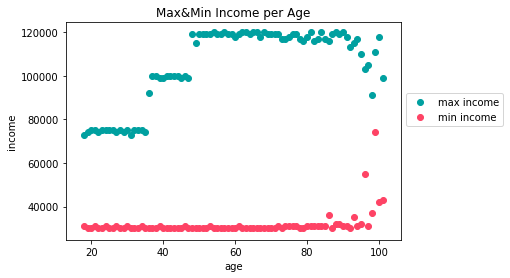

In [18]:
max_income_age = profile.groupby('age').max()
min_income_age = profile.groupby('age').min()
plt.figure(figsize = (6,4))
plt.scatter(max_income_age.index, max_income_age.income, c = '#00A0A0');
plt.scatter(min_income_age.index, min_income_age.income, c = '#FE4365');
plt.xlabel('age');
plt.ylabel('income');
plt.title('Max&Min Income per Age')
plt.legend(['max income', 'min income'], bbox_to_anchor=(1.00, 0.5), loc=3);

In [19]:
# find the 2 age boundary that distinguish income range
income_leap = []
for i in range(profile.age.min(), profile.age.max()):
    diff = max_income_age.loc[i+1].income - max_income_age.loc[i].income
    if diff >= 10000:
        income_leap.append(i+1)
    if len(income_leap) == 2:
        break

income_leap

[36, 48]

It is unclear why the shape of the income between age looks like stairs. There are two obvious steps at age 36 and 48. And the maximum of the income is flat at each step surface. No clean will be done to this phenomenon since the reason behind is unknown and the trend is reasonable.

In [20]:
# get dummy features with gender data and drop original column
profile = pd.concat([profile, pd.get_dummies(profile.gender).iloc[:,:-1]], axis = 1)
profile.head()
profile = profile.set_index('id')

In [21]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [22]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

The 'value' column is a complicated dict. Simplification is needed for further analysis:
- Rows of event is either 'offer received', 'offer viewed', or 'offer completed' rows will extract offer id in a new added column named 'offer_id'
- Rows of event is 'transaction' will extract the amount figure and in the new 'offer_id' column leave 'NA'

In [23]:
transcript['offer_id'] = 'NA'

In [24]:
rec_and_view = transcript[transcript.event.isin(['offer received', 'offer viewed'])]
complete = transcript[transcript.event == 'offer completed']
transactions = transcript[transcript.event == 'transaction']

In [25]:
rec_and_view.loc[:, 'offer_id'] = rec_and_view.loc[:, 'value'].apply(lambda x: x['offer id'])
rec_and_view.loc[:, 'value'] = 0
complete.loc[:, 'offer_id'] = complete.loc[:, 'value'].apply(lambda x: x['offer_id'])
complete.loc[:, 'value'] = 0
transactions.loc[:, 'value'] = transactions.loc[:, 'value'].apply(lambda x: x['amount'])

E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
transcript = pd.concat([rec_and_view, complete, transactions])
transcript.sort_index(inplace=True)

In [27]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 5 columns):
event       306534 non-null object
person      306534 non-null object
time        306534 non-null int64
value       306534 non-null float64
offer_id    306534 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 14.0+ MB


The next step is to combine the profile and transcript into one table.

The procedure of the cleaning would be:
1. Create a new dataframe. The column includes each offer type, 'trans_with_offer'(transaction made under influence of offer),  'trans_tot'(total transaction amount) and 'trans_num'(how many times transaction happened in the transcript). All the offer column value default to NaN. All the trans column value default to 0. The index is profile's personal id
2. Iterate through the id in profile
3. Use person_trans_recs() to pull everyone's personal transaction record
4. Add 1 to the related column, once there is an offer received, offer viewed and offer completed for the same offer with type BOGO or discount
5. Add 0 to the related column, if all offers received, offer viewed are not completed at the end for the same offer with type BOGO or discount
6. Add 1 to the related column, once there is an offer received, offer viewed and transaction happened within valid period of an offer with offer type informational
7. Add 0 to the related column, if all offer received, offer viewed and no transaction happened within valid period of an offer with offer type informational
8. Record time of each type offer that is effective to each customer (view before offer expires or completes)
9. Average each offer type score for a customer by his offer effective times
10. Transaction amount made for step 4 and 6 will be added to 'trans_with_offer'
11. Total transaction amount will be added to 'trans_tot'
12. After the iteration two new columns will be added to dataframe:
    - A column named 'trans_avg', average amount calculated from 'tot_amount' divided by 'trans_times':
    $trans\_avg = \frac{trans\_tot}{trans\_num+0.001}$
    - A column named 'off_drive_ratio', transaction amount spent ratio influenced by offer: $ off\_drive\_ratio = \frac{trans\_with\_offer}{trans\_tot+0.001}$
13. Remove column 'trans_with_off', 'trans_num'
14. Combine the new dataframe with profile on the person id key

In [28]:
# step 1
cols = portfolio.id.values
profile_trans = pd.DataFrame(np.nan, index = profile.index.values, columns = cols)
cols_2 = ['trans_with_off','trans_num','trans_tot']
profile_trans2 = pd.DataFrame(np.zeros((profile.shape[0], 3)), index = profile.index.values, columns = cols_2)
profile_trans = pd.concat([profile_trans, profile_trans2], axis = 1)

In [29]:
# pull offer id related with type to further deal with step 4 and step 5
bogo_disc_offer_ids = portfolio[portfolio.offer_type.isin(['bogo', 'discount'])].id.values

In [30]:
def timer(start_time=None):
    '''print time consumed for the progress
    INPUT:
        start_time: local date and time at the progress begin, default is None
    
    OUTPUT:
        start_time: If INPUT is None, local date time will be recorded as the start time
    '''
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print(f'\n Time taken: {thour} hours {tmin} minutes and {round(tsec, 2)} seconds.')

In [31]:
# function to pull each customer's transcripts
def get_trans_recs(customer_id):
    '''get personal transaction records in transcript data with personal id from profile data
    INPUT:
        customer_id(str): id from profile id
    
    OUTPUT:
        trans_recs(DataFrame): Personal transaction record
    '''
    trans_recs = transcript[transcript.person == customer_id].reset_index(drop=True)
    return trans_recs

In [ ]:
# set up a progress bar
start_time = timer()

cnter = 0
pbar = progressbar.ProgressBar(maxval=profile_trans.shape[0], widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

# step 2
for cus_ind in range(profile.shape[0]): 
    # update progress bar
    cnter+=1 
    pbar.update(cnter)
    
    # step 3 to 11
    cus_id = profile_trans.index[cus_ind]
    trans_recs = get_trans_recs(cus_id) # pull his/her transcripts
    off_comp_times = defaultdict(int) # record times of offer complete after viewed
    off_view_times = defaultdict(int) # record times of offer viewed before complete 
    receive_idx = trans_recs[trans_recs.event == 'offer received'].index.values # save all offer received event index
    trans_row = trans_recs[trans_recs.event == 'transaction'] # save all transaction events
    profile_trans.loc[cus_id, 'trans_num'] = trans_row.shape[0] # save the number of transactions
    profile_trans.loc[cus_id, 'trans_tot'] = trans_row.value.sum() # save the total transaction value
    trans_offer_idx = []

    for receive_ind in receive_idx:
        off_id = trans_recs.loc[receive_ind, 'offer_id'] # pull the offer id
        off_hours = int(portfolio[portfolio.id == off_id].duration) * 24 # offer duration hour
        off_start = trans_recs.loc[receive_ind, 'time']
        off_end = off_start + off_hours
            
        view_row = trans_recs[(trans_recs.offer_id == off_id) & 
                            (trans_recs.event == 'offer viewed') & 
                            (trans_recs.time >= off_start) & 
                            (trans_recs.time <= off_end)] # get offer viewed rows
        if view_row.shape[0] < 1:
            continue # go to next iteration
        else:
            if off_id in bogo_disc_offer_ids:
                comp_row = trans_recs[(trans_recs.offer_id == off_id) & 
                                    (trans_recs.event == 'offer completed') & 
                                    (trans_recs.time >= off_start) & 
                                    (trans_recs.time <= off_end)] # get offer completed rows
            
                if comp_row.shape[0] < 1: # offer is not completed
                    off_view_times[off_id] += 1
                    off_comp_times[off_id] += 0 # viewed and not completed offer
                else:
                    view_ind = view_row.index[0]
                    comp_ind = comp_row.index[0]
                    
                    if view_ind < comp_ind: # complete after view validly count
                        off_view_times[off_id] += 1
                        off_comp_times[off_id] += 1 # viewed and completed the offer
                        trans_offer_idx.extend(trans_row.loc[view_ind:comp_ind].index.values)
                    
                    else: # complete before view not count
                        continue
            else: # Informational offer
                view_time = view_row.iloc[0].time
                off_view_times[off_id] += 1
                info_trans_row = trans_recs[(trans_recs.time >= view_time) & 
                                            (trans_recs.time <= off_end) & 
                                            (trans_recs.event == 'transaction')]

                if info_trans_row.shape[0] > 0: # if there is transaction after view and before offer duration
                    off_comp_times[off_id] += 1 # effective offer                    
                else: 
                    off_comp_times[off_id] += 0 # ineffective offer                  
            
    for i in off_view_times.keys():
        # calculate effective rate of the offer on that customer
        profile_trans.loc[cus_id, i] = round(off_comp_times[i] / off_view_times[i], 2)
    if len(trans_offer_idx) > 0: # calculate the sum of transaction driven by offer
        profile_trans.loc[cus_id, 'trans_with_off'] = trans_row.loc[list(set(trans_offer_idx))].value.sum()
        
pbar.finish()
timer(start_time)
profile_trans.to_csv('profile_trans_1.csv')

In [32]:
profile_trans = pd.read_csv('profile_trans_1.csv', index_col = 'Unnamed: 0')

In [33]:
# step 12 and 13
profile_trans['trans_avg'] = round(profile_trans['trans_tot'] / (profile_trans['trans_num']+0.001), 2) # incase trans_num is 0
profile_trans['off_drive_ratio'] = round(profile_trans['trans_with_off'] / (profile_trans['trans_tot']+0.001), 2) # incase trans_tot is 0
profile_trans.drop(['trans_with_off', 'trans_num'], axis=1, inplace=True)

# keep gender in is not for training but for further illustration with figure
profile_trans = pd.concat([profile.loc[:, ['age', 'income', 'gender', 'F', 'M']], profile_trans], axis=1) 
profile_trans.columns = ['age', 'income', 'gender', 'F', 'M', 'offer_1', 'offer_2', \
                         'offer_3', 'offer_4', 'offer_5', 'offer_6', 'offer_7', 'offer_8',\
                         'offer_9', 'offer_10', 'trans_tot', 'trans_avg', 'off_drive_ratio']

Since a profile_trans data has been built. Some figures can be made to get a rough idea about how is the customer reacted to offer and what is the distribution of the customer transaction

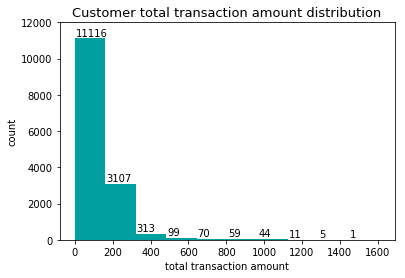

In [34]:
hist_val = plt.hist(profile_trans.trans_tot,bins=10)
plt.hist(profile_trans.trans_tot,bins=10,color = '#00A0A0')
for i in range(10):
    plt.text(hist_val[1][i]+5, hist_val[0][i]+150, int(hist_val[0][i]))
plt.ylim(0,12000)
plt.xlabel('total transaction amount')
plt.ylabel('count')
plt.title('Customer total transaction amount distribution', fontsize=13);

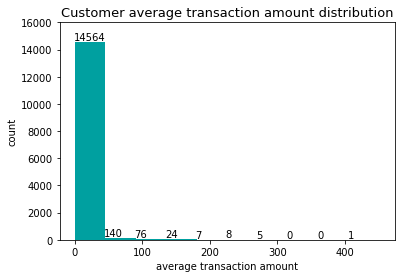

In [35]:
hist_val = plt.hist(profile_trans.trans_avg,bins=10)
plt.hist(profile_trans.trans_avg,bins=10,color = '#00A0A0')
for i in range(10):
    plt.text(hist_val[1][i]-2, hist_val[0][i]+150, int(hist_val[0][i]))
plt.ylim(0,16000)
plt.xlabel('average transaction amount')
plt.ylabel('count')
plt.title('Customer average transaction amount distribution', fontsize=13);

It turns out some outliers are within both the total and average transaction amount data. The high outlier would be removed before training.

In [36]:
tot_p3, tot_p1 = np.percentile(profile_trans.trans_tot, 75), np.percentile(profile_trans.trans_tot, 25)
avg_p3, avg_p1 = np.percentile(profile_trans.trans_avg, 75), np.percentile(profile_trans.trans_avg, 25)
tot_up = tot_p3 + 1.5 * (tot_p3 - tot_p1)
avg_up = avg_p3 + 1.5 * (avg_p3 - avg_p1)

In [37]:
profile_trans = profile_trans[(profile_trans.trans_tot <= tot_up) & (profile_trans.trans_avg <= avg_up)]
profile_trans.shape

(14349, 18)

After the clean work, get some relevant features' descriptive stats

In [38]:
cols = ['age', 'income', 'trans_tot', 'trans_avg', 'off_drive_ratio']
ds = profile_trans.loc[:,cols].describe()

median, skew, kurt = [], [], []
for col in cols:
    median.append(profile_trans[col].median())
    skew.append(profile_trans[col].skew())
    kurt.append(profile_trans[col].kurtosis())

three_rows = np.array([median, skew, kurt])
three_rows
ds = pd.concat([ds, pd.DataFrame(three_rows, index=['median', 'skew', 'kurtosis'],
                                columns = cols)], axis = 0)
ds

,age,income,trans_tot,trans_avg,off_drive_ratio
count,14349.000000,14349.000000,14349.000000,14349.000000,14349.000000
mean,54.320022,65093.246916,100.125469,13.150817,0.259463
std,17.389590,21511.958856,80.343837,9.034411,0.235436
min,18.000000,30000.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,30.180000,3.620000,0.000000
50%,55.000000,63000.000000,82.600000,13.510000,0.230000
75%,66.000000,79000.000000,152.620000,20.680000,0.400000
max,101.000000,120000.000000,354.770000,42.600000,1.000000
median,55.000000,63000.000000,82.600000,13.510000,0.230000
skew,-0.077714,0.413977,0.804864,0.214580,0.892070


In the 5 features, mean and median is located very close which means there's no more outlier affecting the data quality. In the age column, the skew is near the 0 and kurtosis is -0.506, not so far from the normal distribution. It is noted that the off_drive_ratiohas a high positive 0.892 skew and a positive 0.573 kurtosis, which means quite a few data in this column is centralized in the point of mean.

In [39]:
# define a function to help plot figures
def plot_gender_age_trans_mean(col_name):
    '''Plot scatters, x axis is age, y axis is mean value from col_name, value is colored by gender
    INPUT:
        col_name(str) - column name of trans_tot, trans_avg, and off_drive_ratio
    '''
    female_avg_by_age = profile_trans[profile_trans.gender=='F'].groupby('age').mean()[col_name]
    male_avg_by_age = profile_trans[profile_trans.gender=='M'].groupby('age').mean()[col_name]

    plt.scatter(female_avg_by_age.index, female_avg_by_age, color = '#FE4365');
    plt.scatter(male_avg_by_age.index, male_avg_by_age, color = '#00A0A0');
    plt.xlabel('age');
    plt.legend(['female', 'male'], bbox_to_anchor=(1.00, 0.5), loc=3);

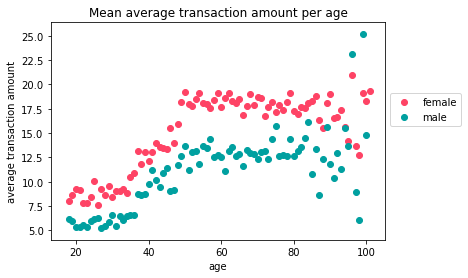

In [40]:
plot_gender_age_trans_mean('trans_avg')

plt.ylabel('average transaction amount');
plt.title('Mean average transaction amount per age', fontsize=12);

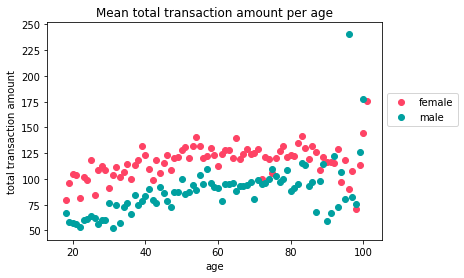

In [41]:
plot_gender_age_trans_mean('trans_tot')

plt.ylabel('total transaction amount');
plt.title('Mean total transaction amount per age', fontsize=12);

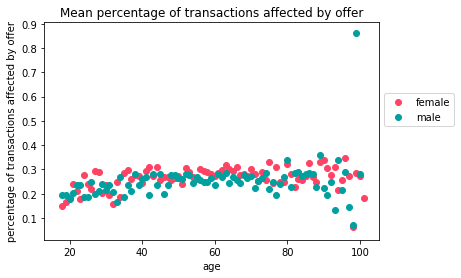

In [42]:
plot_gender_age_trans_mean('off_drive_ratio')

plt.ylabel('percentage of transactions affected by offer');
plt.title('Mean percentage of transactions affected by offer', fontsize=12);

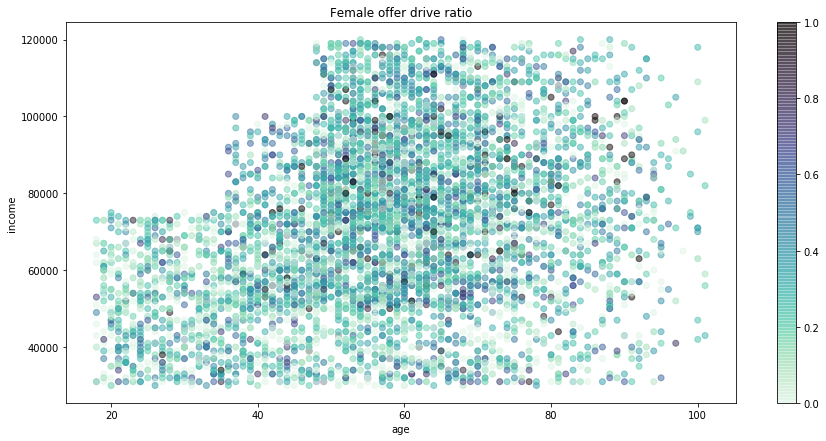

In [43]:
plt.figure(figsize=(15,7))
plt.scatter('age', 'income', c='off_drive_ratio', cmap = 'mako_r', alpha=0.5, data = profile_trans[profile_trans.gender=='F']);
plt.colorbar();
plt.xlabel('age');
plt.ylabel('income');
plt.title('Female offer drive ratio', fontsize = 12);

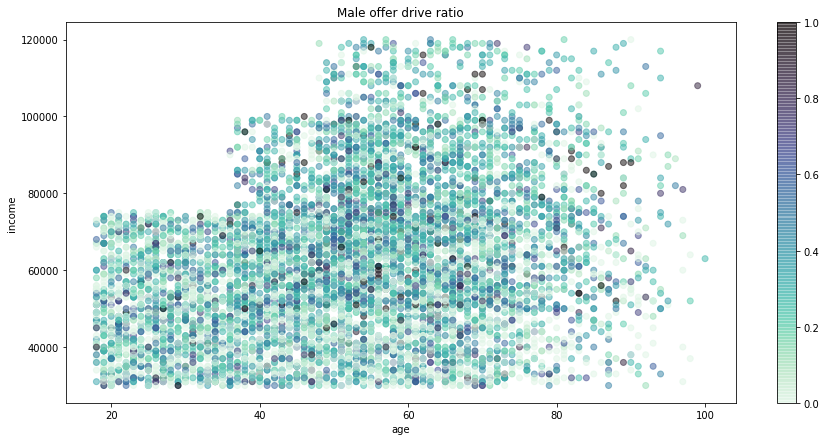

In [44]:
plt.figure(figsize=(15,7))
plt.scatter('age', 'income', c='off_drive_ratio', cmap = 'mako_r', alpha=0.5, data = profile_trans[profile_trans.gender=='M']);
plt.colorbar();
plt.xlabel('age');
plt.ylabel('income');
plt.title('Male offer drive ratio', fontsize = 12);

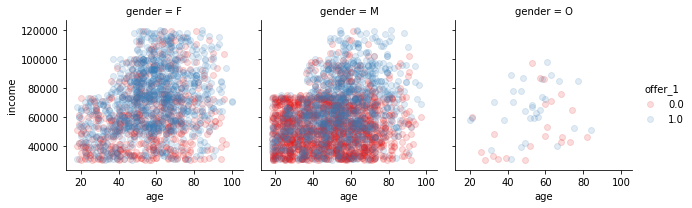

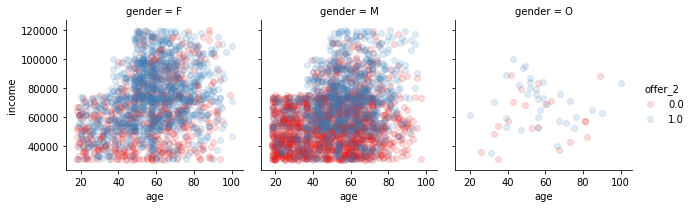

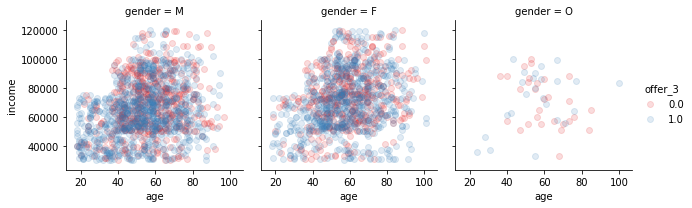

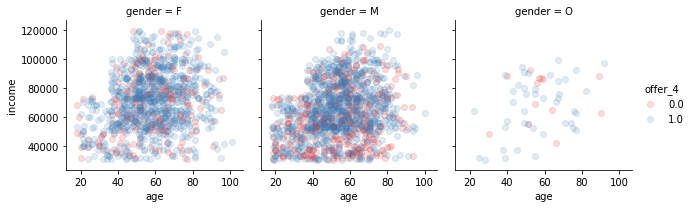

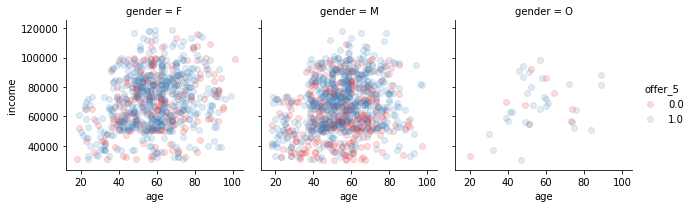

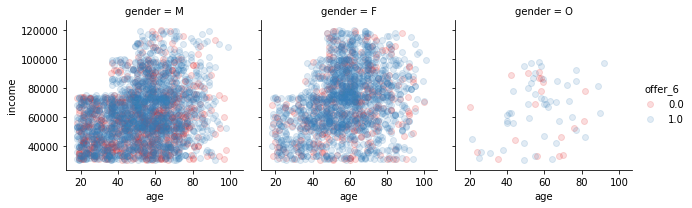

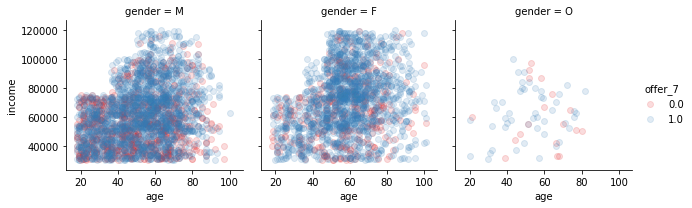

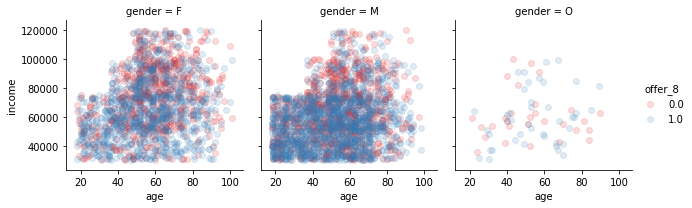

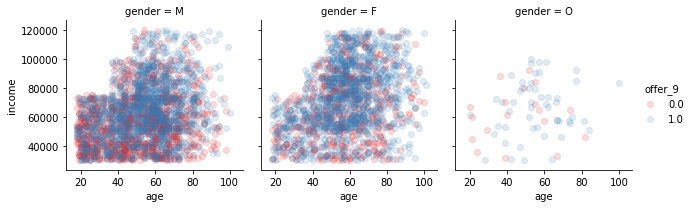

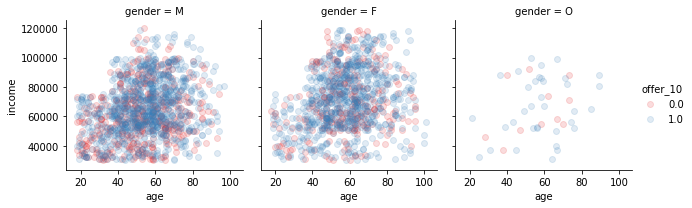

In [45]:
for i in range(10):
    filter_data = profile_trans[(profile_trans.iloc[:,5+i] == 0) | (profile_trans.iloc[:,5+i] == 1)]
    g = sns.FacetGrid(data = filter_data, col = 'gender', hue='offer_'+str(i+1), palette="Set1");
    g.map(plt.scatter, 'age', 'income', alpha=0.15);
    g.add_legend();
    g.savefig('./fig/offer_compare_'+str(i+1)+'.jpg')

Based on above figures, some interesting conclusions can be found:
1. For each offer type, there is difference between how customer react to it depending on their age, income and gender
2. Male seems to be more offer driven than female
3. The relationship between age and transaction amount seem like linear

For the next chapter, machine learning models will be built to search the relationship for abouve scenes.

### <span id="2">2. Training model</span>

#### 2.1 Classification model
For any customer, his/her reaction to an offer is presented use number between 0 to 1. 0 means he/she has no interest to use offer and 1 has the opposite meaning.

Random Forest will be picked as the algorithm for the following reasons:
- Random Forest algorithm can avoid over-fitting
- Random Forest algorithm is good at handling non-linear feature
- Random Forest algorithm can both do classfication and regression

In [46]:
def classify_train_data(test_col, profile_trans = profile_trans):
    '''filter profile_trans data of customer with 1 or 0 score under dedicated offer id
    INPUT:
        test_col(str) - test data column name
        profile_trans(pandas DataFrame) - profile_trans dataframe
    OUTPUT:
        X(pandas DataFrame) - training data features
        y(pandas DataFrame) - training data label
    '''
    train_data = profile_trans[(profile_trans.loc[:,test_col] == 1) | \
                                  (profile_trans.loc[:,test_col] == 0)].loc[:, ['age','income','F','M', test_col]]
    X, y = train_data.iloc[:,:4], train_data.iloc[:,-1]
    return X, y

def classify_grid_search(X, y):
    '''grid search and cross validation with estimator of random forest classifier 
    INPUT:
        X(pandas DataFrame) - training data features
        y(pandas DataFrame) - training data label
    OUTPUT:
        grid_clf(sklearn model instance) - trained model
    '''
    clf = RandomForestClassifier()
    
    param_dist = {'n_estimators': [50, 100, 200],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [5, 7, 10, 15, None],
                  'min_samples_split': [2, 3, 5, 7]
                 }
    
    scoring = {'Precision': 'precision', 'Recall': 'recall', 'F1': 'f1'}
    
    grid_clf = GridSearchCV(clf, param_dist, scoring = scoring, refit = 'F1', cv=5, return_train_score=False)
    grid_clf.fit(X, y)
    
    return grid_clf

In [47]:
clfs = [] # store each model
model_F1 = [] # store F1 score for each model

In [ ]:
offer_list = profile_trans.columns[5:15]
start_time = timer()

# set up progressbar
cnter = 0
pbar = progressbar.ProgressBar(maxval=len(offer_list), widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

for i, offer_num in enumerate(offer_list):
    cnter+=1 
    pbar.update(cnter)
    
    X, y = classify_train_data('offer_num')
    
    grid_clf = classify_grid_search(X, y)
    joblib.dump(grid_clf, './clf_best_mdls/clf_'+str(i+1)+'.model')
    clfs.append(grid_clf)
    
    result = pd.DataFrame(grid_clf.cv_results_)
    result.to_csv('./clf_results/clf_'+str(i+1)+'.csv')
    model_f1 = round(int(result[result.rank_test_F1 == 1]['mean_test_F1'].values[0]*100000)/1000,2)
    model_F1.append(model_f1)

pbar.finish()
timer(start_time)

In [49]:
# load clf models
clfs = []
for i in range(10):
    name = 'clf_' + str(i)
    locals()[name] = joblib.load('./clf_best_mdls/clf_'+str(i+1)+'.model')
    clfs.append(locals()[name])
    result = pd.read_csv('./clf_results/clf_'+str(i+1)+'.csv')
    model_f1 = round(int(result[result.rank_test_F1 == 1]['mean_test_F1'].values[0]*100000)/1000,2)
    model_F1.append(model_f1)

In [74]:
model_F1

[66.76, 65.98, 74.63, 82.12, 79.34, 83.89, 84.88, 73.61, 72.14, 82.06]

The classification models are capable of predicting probability.
For a customer, it is possible to sort the offer priority using probability and push the most appropriate offers

In [75]:
def trans_personal_info_to_list(age, income, gender):
    '''Convert personal info to needed data shape for model predict
    INPUT:
        age(int): age between 18 to 101
        income(float): income between 30000 to 120000
        gender(str): 'F' for female, 'M' for male, 'O' for other
    OUTPUT:
        person_info(numpy array): data structure fit to model predict
    '''
    gender_dict = {'F': [1, 0],
         'M': [0, 1],
         'O': [0, 0]}
    p = [age, income]
    p.extend(gender_dict[gender])
    person_info = np.array(p).reshape(1,-1)
    return person_info

def pred_top_n_offer_with_person_info(age, income, gender, n=10, clfs=clfs):
    '''predict probability and return top n appropriate offer type with personal info 
    INPUT:
        age(int): age between 18 to 101
        income(float): income between 30000 to 120000
        gender(str): 'F' for female, 'M' for male, 'O' for other
        n(int): the number of top appropriate offer id in the return, from 1 to 10, default 10
        clfs(sklearn models): classifiers used to predict each offer's probability
    OUTPUT:
        top_n(list): top n offer ids with highest probability
    '''
    person_info = trans_personal_info_to_list(age, income, gender)
    pred_probs = []
    for i in range(10):
        prob = clfs[i].predict_proba(person_info)[0][1]
        pred_probs.append(prob)
        
    offer_prob = pd.Series(pred_probs, index=portfolio.id)
    if n > 10:
        n = 10
        
    sorted_offer_prob = offer_prob.sort_values(ascending=False)
    top_n = sorted_offer_prob.index.values[:n]
    return top_n

def pred_top_n_offer_with_cus_id(cus_id, clfs=clfs, n=10, profile_trans=profile_trans):
    '''predict probability and return top n appropriate offer type with customer id 
    INPUT:
        cus_id(str): customer id in profile_trans dataframe
        n(int): the number of top appropriate offer id in the return, default 10
        profile_trans(pandas DataFrame): used to get the customer's personal info
    OUTPUT:
        top_n(list): top n offer ids with highest probability
    '''
    if cus_id in profile_trans.index:
        age, income, gender = profile_trans.loc[cus_id][0:3]
        top_n = pred_top_n_offer_with_person_info(age, income, gender, n)
        return top_n
    else:
        print('Sorry, this is not a valid customer id or this customer id has incomplete personal information')

In [76]:
# try with n = 3
top_3 = pred_top_n_offer_with_person_info(49, 70000, 'F', n=3, clfs=clfs)
top_3

array(['2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9'], dtype=object)

In [77]:
# try with n = 5
top_5 = pred_top_n_offer_with_cus_id('2eeac8d8feae4a8cad5a6af0499a211d', n=5)
top_5

array(['fafdcd668e3743c1bb461111dcafc2a4',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '5a8bc65990b245e5a138643cd4eb9837',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

#### 2.2 Regression model
two regression models will be built:
1. to estimate customer's average transaction amount
2. to predict customer's

In [78]:
def regression_grid_search(X, y):
    '''grid search and cross validation with estimator of linear regression 
    INPUT:
        X(pandas DataFrame) - training data features
        y(pandas DataFrame) - training data label
    OUTPUT:
        grid_reg(sklearn model instance) - trained model
    '''
    rgr = RandomForestRegressor()
    
    param_dist = {'n_estimators': [50, 100, 200],
                  'max_depth': [5, 7, 10, None],
                  'min_samples_split': [2, 5, 7, 10]
                 }
    
    scoring = {'R2': 'r2', 'EV': 'explained_variance'}
    
    grid_reg = GridSearchCV(rgr, param_dist, scoring = scoring, refit = 'R2', cv=5, return_train_score=False)
    grid_reg.fit(X, y)
  
    return grid_reg

In [ ]:
rgrs = []
profile_trans_reg = profile_trans.loc[:,['age', 'income', 'F', 'M', 'trans_avg', 'off_drive_ratio']]
start_time = timer()

# set up progressbar
cnter = 0
pbar = progressbar.ProgressBar(maxval=2, widgets=[progressbar.Bar('=', '[', ']'), progressbar.Percentage()])
pbar.start()

for i in range(2):
    cnter += 1
    pbar.update(cnter)
    
    X = profile_trans_reg.iloc[:, :4]
    y = profile_trans_reg.iloc[:, 4+i]
    
    grid_rgr = regression_grid_search(X, y)
    
    joblib.dump(grid_rgr, './rgr_best_mdls/rgr_'+str(i+1)+'.model')
    rgrs.append(grid_rgr)
    
    result = pd.DataFrame(grid_rgr.cv_results_)
    result.to_csv('./rgr_results/rgr_'+str(i+1)+'.csv')

pbar.finish()
timer(start_time)

In [79]:
# load rgr models
rgrs = []
for i in range(2):
    name = 'rgr_' + str(i)
    locals()[name] = joblib.load('./rgr_best_mdls/rgr_'+str(i+1)+'.model')
    rgrs.append(locals()[name])

In [80]:
def pred_avg_and_ratio_with_person_info(age, income, gender, rgrs=rgrs):
    '''predict average transaction amount and offer drive ratio with personal info 
    INPUT:
        age(int): age between 18 to 101
        income(float): income between 30000 to 120000
        gender(str): 'F' for female, 'M' for male, 'O' for other
        clfs(sklearn models): classifiers used to predict each offer's probability
    OUTPUT:
        pred_results(list): customer average transaction amount and offer drive ratio
    '''
    person_info = trans_personal_info_to_list(age, income, gender)
    pred_results = []
    for i in range(2):
        pred = round(rgrs[i].predict(person_info)[0], 2)
        pred_results.append(pred)

    return pred_results

def search_avg_and_ratio_with_cus_id(cus_id, profile_trans=profile_trans):
    '''search customer id and return average transaction amount and offer drive ratio
    INPUT:
        cus_id(str): customer id in profile_trans dataframe
        profile_trans(pandas DataFrame): used to get the customer's personal info
    OUTPUT:
        [avg(float), ratio(float)](list): customer average transaction amount and offer drive ratio in a list
    '''
    if cus_id in profile_trans.index:
        avg, ratio = profile_trans.loc[cus_id][-2:].values 
        return [avg, ratio]
    else:
        print('Sorry, this is not a valid customer id or this customer id has incomplete personal information')

In [81]:
# try a group of people
m_25_40000 = pred_avg_and_ratio_with_person_info(25, 40000, 'M')
f_45_80000 = pred_avg_and_ratio_with_person_info(45, 80000, 'F')
print(m_25_40000, f_45_80000)

[4.77, 0.21] [20.11, 0.31]


In [82]:
cus_id_avg_and_ratio = search_avg_and_ratio_with_cus_id('2eeac8d8feae4a8cad5a6af0499a211d')
cus_id_avg_and_ratio

[3.9, 0.8]

#### 2.3 Application 
Finally, combine two function together and make the output more clear and detailed

In [83]:
def offer_suggest_and_cons_habit_predict(age, income, gender, n=10):
    '''predict top n most appropriate offer, average transaction amount, offer driven ratio based on personal information 
    INPUT:
        age(int): age between 18 to 101
        income(float): income between 30000 to 120000
        gender(str): 'F' for female, 'M' for male, 'O' for other
        n(int): the number of top appropriate offer id in the return, from 1 to 10, default 10
    OUTPUT:
        offer_sugg(pandas DataFrame): DataFrame of top n suggested offer in order of index
        pred_results(list): customer average transaction amount and offer drive ratio
    '''
    top_n = pred_top_n_offer_with_person_info(age, income, gender, n)
    offer_sugg = portfolio.set_index('id', drop=True).loc[top_n]
    pred_results = pred_avg_and_ratio_with_person_info(age, income, gender)
    
    return offer_sugg, pred_results

def offer_suggest_to_cus_id(cus_id, n=10):
    '''predict top n most appropriate offer, average transaction amount, offer driven ratio based on personal information 
    INPUT:
        cus_id(str): customer id in profile_trans dataframe
        n(int): the number of top appropriate offer id in the return, from 1 to 10, default 10
    OUTPUT:
        offer_sugg(pandas DataFrame): DataFrame of top n suggested offer in order of index
        pred_results(list): customer average transaction amount and offer drive ratio
    '''
    if cus_id in profile_trans.index:
        top_n = pred_top_n_offer_with_person_info(cus_id, n)
        offer_sugg = portfolio.set_index('id', drop=True).loc[top_n]
        pred_results = search_avg_and_ratio_with_cus_id(cus_id)

        return offer_sugg, pred_results
    else:
        print('Sorry, this is not a valid customer id or this customer id has incomplete personal information')

In [84]:
# try with some makeup data
off_sugg, preds = offer_suggest_and_cons_habit_predict(40, 53000, 'F', n=3)

In [85]:
off_sugg

,channels,difficulty,duration,offer_type,reward
id,,,,,
fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,10,discount,2
2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,7,discount,3
2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,7,discount,2


In [86]:
preds

[11.54, 0.28]

## <span id="3"> 3. Conclusion</span>

### 3.1 Achievement of the project
In this project, a data cleaning has been done to combine both profile data and transcript data together. The profile_trans dataframe can be used to create lots of informational figures as the chapter 1 shows.

A series of models has been built up to select the best appropriate offer to customer, to estimate the customer's average transaction amount and to predict whether the customer consumes only affected by offer or not.

The classification model has an average 0.77 F1 score on each offer type. An function is built on these classifiers to provide the customed number of most appropriate offer suggestion to either customer with id or new customer.

### 3.2 Deficit of the project
- It is unclear why the income data for the customers seem to have restriction. People whose age is between age 18 to 35 share the same highest income 75000. People aged between 36 to 47 can improve to 100000 while who aged above 48 can have the upper limit of 120000. The limitaiton may lead to the income feature difficult to used to predict by model.
- The best average result of the classification model's F1-score can reach at 0.77. But it is very difficult to say how is the model's accuracy on ranking different offer types (maybe it's also an unanswerable question to a customer ). The effort to find out hidden rules may be proven wrong in some time in future and could be altered with the customer's aging and income's varying. So it is better to update the model with the latest data once after a period of time.
- The regression models perform not as well as classification models. The reason may come from that the data has not scattered on the features provided, most data point centralized at a specific point (As noted in the descriptive statistical part of off_drive_ratio). The habit of consumption maybe not only related to age, gender, and income but also influenced by personality, occupation, and location. However, the current model can provide a rough view of how to evaluate a customer's potential value..


### 3.3 Further Improvement
Many further applications and improvements can be made relying on the achievements:
- The push offer type can be based on the customer's average transaction amount. Push lower duration offer to customer with high average amount, which can stimulate their consumption frequency
- For customer with high average transaction amount, the offer's duration should avoid overlap to prevent the customer from completing plural offers with a single order
- For customer with low offer drive ratio, the frequency of offer sending can be reduced to maximize revenue or only push informational
- The offer in different category can add weight based on how long since the customer joined as member. For customer just become member, the discount category will have larger weight. So it is more likely to be pushed to ensure customer enjoying the feel of becoming a member. For customer has longer membership experience, the BOGO category will have larger weight, to encourage the customer share with his/her friend or family that can possibly attract new member
- Improve the regression model with more important features(transcript on weekday or weekend, location, education)